<a href="https://colab.research.google.com/github/jagatabhay/TSAI/blob/master/S8/S8_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device : ' , device )

Device :  cuda


In [0]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(nn.Conv2d(in_planes, self.expansion*planes,kernel_size=1, stride=stride, bias=False),
                                          nn.BatchNorm2d(self.expansion*planes)
                                          )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [0]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [4]:
!pip install torchsummary
from torchsummary import summary
net = ResNet(BasicBlock, [2, 2, 2, 2]).to(device)
summary(net, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

In [5]:
%matplotlib inline
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose( [transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_transform = transforms.Compose( [transforms.RandomHorizontalFlip(p=0.5),
                                       transforms.RandomCrop(32, padding=2),
                                       transforms.ColorJitter(brightness=0.1, contrast=0.1,saturation=0.1,hue=0.1),
                                       #transforms.RandomRotation( degrees = 7 ),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', 
                                        train=True,
                                        download=True,
                                        transform = train_transform)

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size = 4,
                                          shuffle=True, 
                                          num_workers = 4)

testset = torchvision.datasets.CIFAR10(root='./data', 
                                       train=False,
                                       download=True, 
                                       transform=transform)
testloader = torch.utils.data.DataLoader(testset,
                                         batch_size = 4,
                                         shuffle=False,
                                         num_workers = 4)

classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


 bird  frog   cat  ship


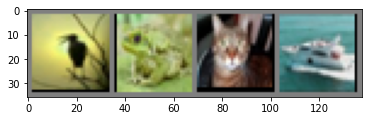

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [0]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9 , weight_decay = 0.001 )
scheduler= StepLR(optimizer,step_size=5,gamma=0.1)

In [8]:
for epoch in range(15):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data[0].to(device) , data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0


[1,  2000] loss: 2.057
[1,  4000] loss: 1.702
[1,  6000] loss: 1.483
[1,  8000] loss: 1.347
[1, 10000] loss: 1.226
[1, 12000] loss: 1.143
[2,  2000] loss: 1.027
[2,  4000] loss: 0.988
[2,  6000] loss: 0.942
[2,  8000] loss: 0.927
[2, 10000] loss: 0.871
[2, 12000] loss: 0.863
[3,  2000] loss: 0.789
[3,  4000] loss: 0.788
[3,  6000] loss: 0.780
[3,  8000] loss: 0.743
[3, 10000] loss: 0.723
[3, 12000] loss: 0.708
[4,  2000] loss: 0.679
[4,  4000] loss: 0.671
[4,  6000] loss: 0.673
[4,  8000] loss: 0.647
[4, 10000] loss: 0.647
[4, 12000] loss: 0.629
[5,  2000] loss: 0.616
[5,  4000] loss: 0.599
[5,  6000] loss: 0.591
[5,  8000] loss: 0.582
[5, 10000] loss: 0.605
[5, 12000] loss: 0.581
[6,  2000] loss: 0.540
[6,  4000] loss: 0.560
[6,  6000] loss: 0.561
[6,  8000] loss: 0.538
[6, 10000] loss: 0.548
[6, 12000] loss: 0.546
[7,  2000] loss: 0.516
[7,  4000] loss: 0.509
[7,  6000] loss: 0.515
[7,  8000] loss: 0.511
[7, 10000] loss: 0.503
[7, 12000] loss: 0.502
[8,  2000] loss: 0.483
[8,  4000] 

In [9]:
'''outputs = net(images)'''

'outputs = net(images)'

In [10]:
'''_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))'''

"_, predicted = torch.max(outputs, 1)\n\nprint('Predicted: ', ' '.join('%5s' % classes[predicted[j]]\n                              for j in range(4)))"

In [11]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device) , data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 85 %


In [12]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device) , data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 86 %
Accuracy of   car : 88 %
Accuracy of  bird : 79 %
Accuracy of   cat : 60 %
Accuracy of  deer : 89 %
Accuracy of   dog : 82 %
Accuracy of  frog : 89 %
Accuracy of horse : 94 %
Accuracy of  ship : 93 %
Accuracy of truck : 93 %
